<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation-with-Deep-Learning/blob/master/src/DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Insert an integer value for the DATASET_CHOICE variable below
# 0 = Symbol Set
# 1 = cifar10 (You can also choose a class with the CIFAR10_CLASS variable)
# 2 = Celeb faces
# 3 = ImageNette (You must choose a category with the IMAGENETTE_CATEGORY variable)
DATASET_CHOICE = 1

# If you wish to use a specific cifar10 class, specify one here, otherwise assign the variable to None
# 0 = airplane
# 1 = automobile
# 2 = bird
# 3 = cat
# 4 = deer										
# 5 = dog
# 6 = frog
# 7 = horse
# 8 = ship
# 9 = truck
CIFAR10_CLASS = 0

# If using imagenette specify the image category to train on here
# Choose one of the following: "dog", "paraglider", "golfball", "church", "fish"
IMAGENETTE_CATEGORY = "dog"

# Define Global Parameters

In [0]:
IMAGE_COUNT = 50000
TRAINING_IMAGE = 0
TEST_IMAGE = 0
BATCH_SIZE = 1024
# BATCH_SIZE = 512
# BATCH_SIZE = 128
# BATCH_SIZE = 32
# BATCH_SIZE = 16
LEARNING_RATE = 0.0001
# LEARNING_RATE = 0.001
# LEARNING_RATE = 0.01
MOMENTUM = 0.0
CLASSIFICATION_EPOCHS = 1000
COLOURISATION_EPOCHS = 100
LOAD_COLOURISATION_MODEL = False
INPUT_IMAGE = 10

# Library Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import layers, models, backend, utils, optimizers, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive, files
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

drive.mount("/content/gdrive", force_remount=True)
base_dir = "/content/gdrive/My Drive/Neural Network Models/"

TensorFlow 2.x selected.
Mounted at /content/gdrive


# Dataset Setup

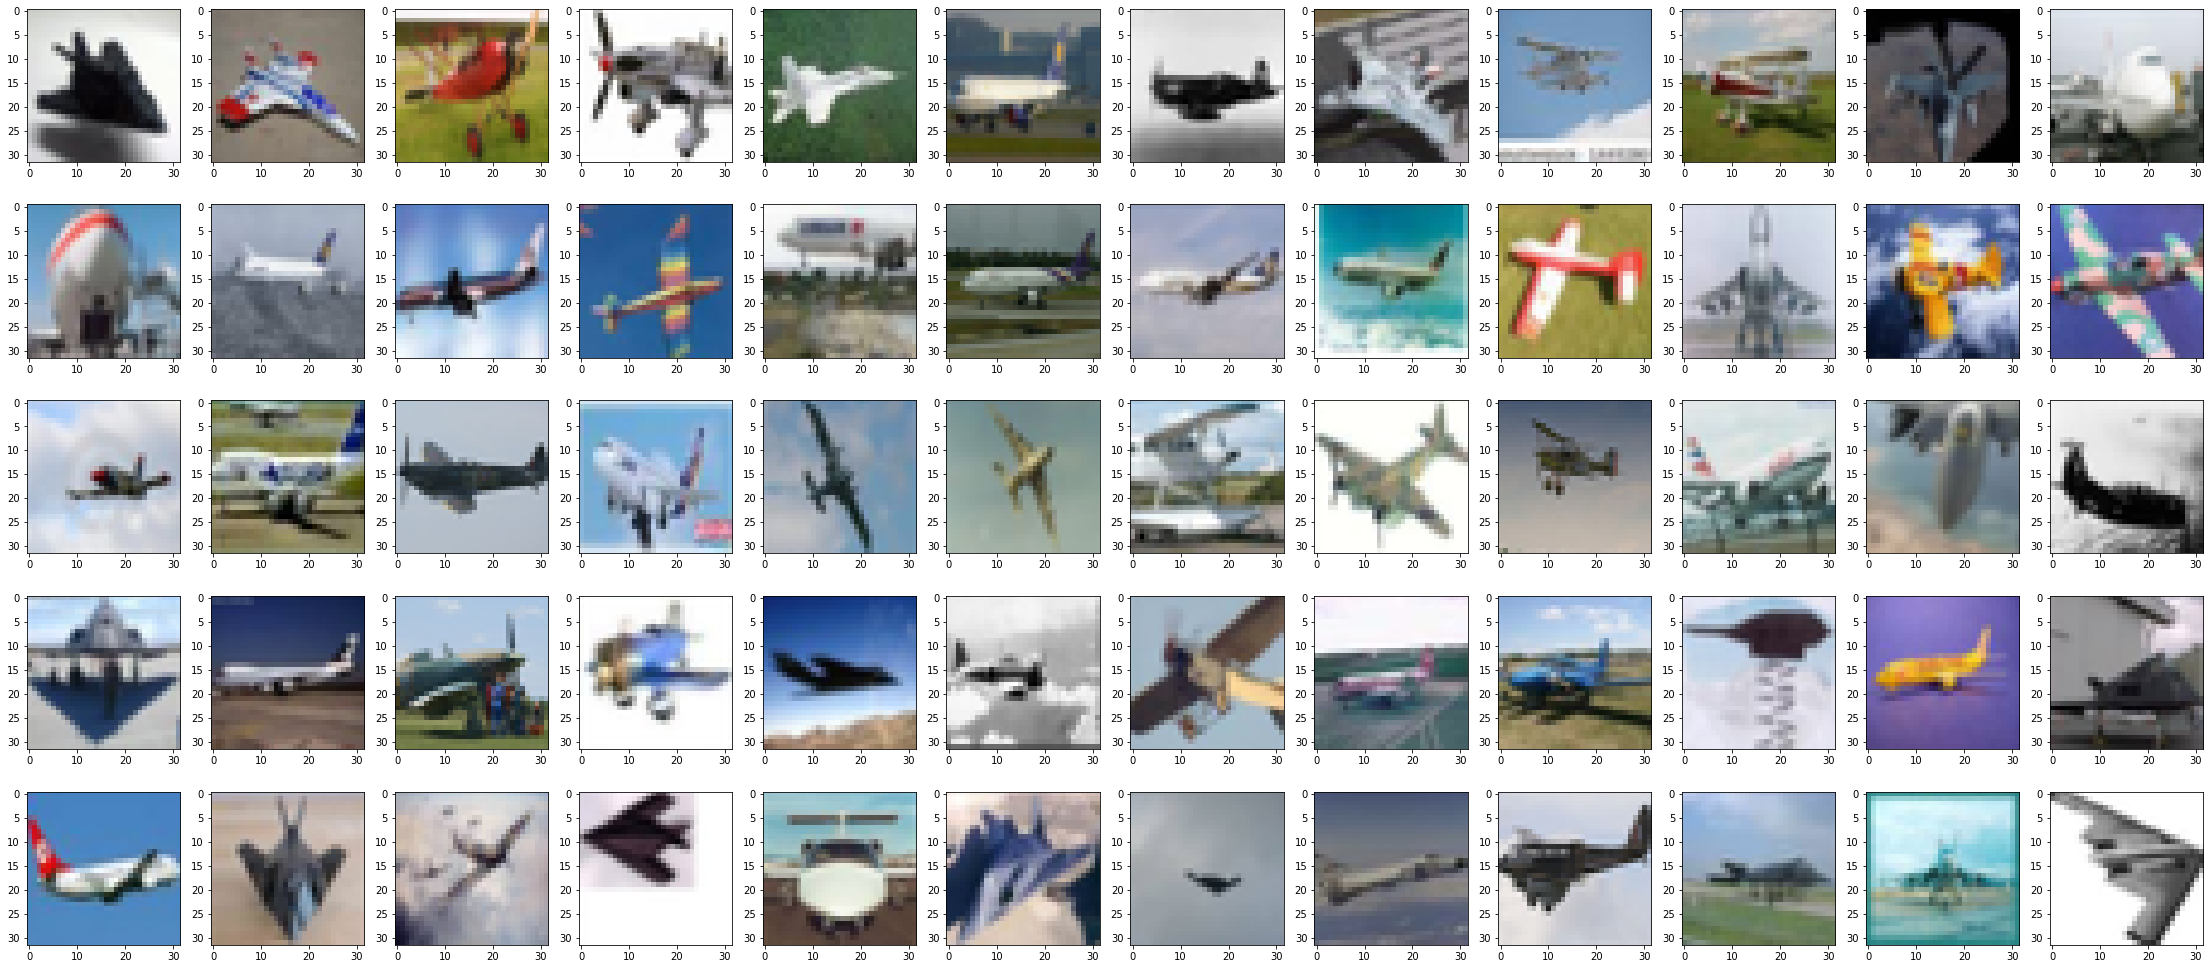

In [0]:
# TODO: DECIDE ON GITHUB OR DRIVE FOR HOSTING
# TODO: ADD CODE TO SAVE TRAINED MODEL
if(DATASET_CHOICE == 0):
  from google.colab import drive, files
  drive.mount("/content/gdrive", force_remount=True)
  !unzip -uq "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/SymbolSet.zip" -d "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/" 
  base_dir = "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/Symbol Set"

  images = []
  for image in io.imread_collection(base_dir + "/*.jpg"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images[1:-1:2])
  test_images = np.array(images[0:-2:2])

  output_count = 9
  index_offset = 0

  print(train_images.shape)

  indexes = np.array([np.arange(5,8)])
  indexes = np.append(indexes, np.arange(8,11))
  indexes = np.append(indexes, np.arange(20,23))
  output_images = np.array(images)[indexes]
  fig = plt.figure(figsize=(39, 21))
  for i in range(output_count):
    ax = fig.add_subplot(1,output_count,i+1)
    plt.imshow(output_images[i])

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = (train_images[:,:,:,0] + train_images[:,:,:,1] + train_images[:,:,:,2]) / 3
  train_y = tf.expand_dims(train_y[:,:,:], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = (test_images[:,:,:,0] + test_images[:,:,:,1] + test_images[:,:,:,2]) / 3
  test_y = tf.expand_dims(test_y[:,:,:], 3)
  test_uv = test_yuv[:,:,:,1:]

elif(DATASET_CHOICE == 1):
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  if(CIFAR10_CLASS is not None):
    class_train_indices = np.argwhere(train_labels == CIFAR10_CLASS)
    train_images = train_images[class_train_indices[:,0]]
    train_labels = train_labels[class_train_indices[:,0]]
    class_test_indices = np.argwhere(test_labels == CIFAR10_CLASS)
    test_images = test_images[class_test_indices[:,0]]
    test_labels = test_labels[class_test_indices[:,0]]

  image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      if(CIFAR10_CLASS is None):
        plt.title(image_labels[int(train_labels[count])])
      plt.imshow(train_images[count])
      count += 1

  output_count = 12
  index_offset = 20

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

elif(DATASET_CHOICE == 2):
  !git clone https://github.com/2014mchidamb/DeepColorization/

  images = train_images = test_images = []
  for image in io.imread_collection('DeepColorization/face_images/*.jpg'): 
    images.append(resize(image, (128, 128)))
    
  train_images = np.array(images)[0:-1:2,:,:,:]
  test_images = np.array(images)[1::2,:,:,:]

  index_offset = 20
  output_count = 12
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      plt.imshow(train_images[30+count])
      count += 1

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

elif(DATASET_CHOICE == 3):
  from google.colab import drive, files
  drive.mount("/content/gdrive", force_remount=True)
  base_dir = "/content/gdrive/My Drive/Dissertation/Data/imagenette2-160/"

  categories = {"dog":"n02102040", "paraglider":"n03888257", "golfball":"n03445777", "church":"n03028079", "fish":"n01440764"}
  print("Loading and resizing training and testing images, this may take a few minutes.")
  images = []
  for image in io.imread_collection(base_dir + "train/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images)
  images = []
  for image in io.imread_collection(base_dir + "val/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  test_images = np.array(images)

  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)  
      plt.imshow(train_images[30+count])
      count += 1

  index_offset = 0
  output_count = 12

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

# Create the Colourisation CNN

In [0]:
# Conv2D(filters (number of output filters)
#           - determine parameter number
#        kernel_size (size of convolution window)
#        activation (activation function to use)
#        padding ("valid" or "same")
#        strides (strides of the convolution along the height and width)
#           - strides greater than 1 will downsample
#        input_shape (only used on the first layer of the model))
#
# UpSampling2D(size (upsampling factors for rows and columns))

#https://github.com/emilwallner/Coloring-greyscale-images

# For an odd-sized filter, all the previous layer pixels would be symmetrically 
# around the output pixel. If you think of convolution as an interpolation from 
# the given pixels to a center pixel, we cannot interpolate to a center pixel 
# using an even-sized filter.

# Try a shallower model with the same # of parameters
# Try leaky relu
# Investgiate VAEs
# def create_colourisation_model():
#   model = models.Sequential()
#   model.add(layers.Conv2D(8, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.Conv2D(128, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(8, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(2, (3, 3), activation='tanh', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   opt = optimizers.RMSprop(lr=0.0001, momentum=0.0)
#   model.compile(optimizer=opt, loss='mse')
#   return model

# def create_colourisation_model():
#   model = models.Sequential()
#   model.add(layers.Conv2D(8, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(128, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(128, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(2, (3, 3), activation='tanh', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   opt = optimizers.RMSprop(lr=0.0001, momentum=0.0)
#   model.compile(optimizer=opt, loss='mse')
#   return model

def create_model_very_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='tanh', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  opt = optimizers.RMSprop(lr=0.0001, momentum=0.0)
  model.compile(optimizer=opt, loss='mse')
  return model

def create_model_deep():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  opt = optimizers.RMSprop(lr=0.0001, momentum=0.0)
  model.compile(optimizer=opt, loss='mse')
  return model

def create_basic_final_colourisation_model():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  opt = optimizers.RMSprop(lr=LEARNING_RATE, momentum=MOMENTUM)
  model.compile(optimizer=opt, loss='mse')
  return model

def create_final_colourisation_model():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), bias_regularizer=regularizers.l1(0.00001), input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Conv2D(16, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(32, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(16, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', bias_regularizer=regularizers.l1(0.00001), padding='same'))
  opt = optimizers.RMSprop(lr=0.0001, momentum=0.0)
  model.compile(optimizer=opt, loss='mse')
  return model

if not (LOAD_COLOURISATION_MODEL):
  create_basic_final_colourisation_model().summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         36992     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0


# Train the Colourisation Model

In [0]:
# fit(x (input data)
#     y (target data)
#     batch_size (samples per gradient update)
#        - smaller batch size = more stochastic
#     epochs (epochs to train the model))

#https://stackoverflow.com/questions/47200146/keras-load-images-batch-wise-for-large-dataset

def train_image_loader(x_train, y_train, batch_size):
  datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=60, width_shift_range=0.2, height_shift_range=0.2, brightness_range=(0.5, 1.0), zoom_range=[0.5, 1.5])
  datagen.fit(x_train)
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
      print("\ncount: ", count, " - x_batch.shape: ", x_batch.shape, " - y_batch.shape: ", y_batch.shape)
      yield (x_batch, y_batch)  

def test_image_loader(x_test, y_test, batch_size):
  datagen = ImageDataGenerator()
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_test, y_test, batch_size=batch_size):
      yield (x_batch, y_batch)  

runtime_epochs = int(COLOURISATION_EPOCHS/4)
total_loss = []
total_val_loss = []
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_iterator = datagen.flow(train_y, train_uv, batch_size=BATCH_SIZE)

if not (LOAD_COLOURISATION_MODEL):
  start = time.time()
  model = create_basic_final_colourisation_model()
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE), verbose=1)

  model_json = model.to_json()
  with open(base_dir + "colourisation.json", "w") as json_file:
      json_file.write(model_json)
  model.save_weights(base_dir + "colourisation.h5")
  print("Saved model to disk")

  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 4 steps, validate on 1000 samples
Epoch 1/25
4/4 [==============================] - 6s 2s/step - loss: 0.7276 - val_loss: 0.9575
Epoch 2/25
4/4 [==============================] - 1s 355ms/step - loss: 0.9625 - val_loss: 0.9457
Epoch 3/25
4/4 [==============================] - 1s 355ms/step - loss: 0.3327 - val_loss: 0.4095
Epoch 4/25
4/4 [==============================] - 1s 356ms/step - loss: 0.1058 - val_loss: 0.0045
Epoch 5/25
4/4 [==============================] - 1s 359ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 6/25
4/4 [==============================] - 1s 364ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 7/25
4/4 [==============================] - 2s 382ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 8/25
4/4 [==============================] - 1s 367ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 9/25
4/4 [==============================] - 1s 365ms/step - loss: 0.

In [0]:
if not (LOAD_COLOURISATION_MODEL):
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE), verbose=1)
  # history = model.fit_generator(train_image_loader(train_y, train_uv, BATCH_SIZE), steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_y, test_uv, BATCH_SIZE)), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE))
  
  model_json = model.to_json()
  with open(base_dir + "colourisation.json", "w") as json_file:
      json_file.write(model_json)
  model.save_weights(base_dir + "colourisation.h5")
  print("Saved model to disk")

  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

  ...
    to  
  ['...']
Train for 4 steps, validate on 1000 samples
Epoch 1/25
4/4 [==============================] - 1s 337ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 2/25
4/4 [==============================] - 1s 345ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 3/25
4/4 [==============================] - 1s 368ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 4/25
4/4 [==============================] - 1s 375ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/25
4/4 [==============================] - 1s 352ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 6/25
4/4 [==============================] - 1s 362ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 7/25
4/4 [==============================] - 1s 365ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 8/25
4/4 [==============================] - 2s 375ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 9/25
4/4 [==============================] - 2s 375ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/25
4/4 [==============================] 

In [0]:
if not (LOAD_COLOURISATION_MODEL):
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE), verbose=1)
  # history = model.fit_generator(train_image_loader(train_y, train_uv, BATCH_SIZE), steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_y, test_uv, BATCH_SIZE)), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE))

  model_json = model.to_json()
  with open(base_dir + "colourisation.json", "w") as json_file:
      json_file.write(model_json)
  model.save_weights(base_dir + "colourisation.h5")
  print("Saved model to disk")

  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

  ...
    to  
  ['...']
Train for 4 steps, validate on 1000 samples
Epoch 1/25
4/4 [==============================] - 1s 329ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 2/25
4/4 [==============================] - 1s 336ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 3/25
4/4 [==============================] - 1s 343ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 4/25
4/4 [==============================] - 1s 365ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/25
4/4 [==============================] - 1s 368ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 6/25
4/4 [==============================] - 1s 373ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 7/25
4/4 [==============================] - 1s 364ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 8/25
4/4 [==============================] - 1s 352ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 9/25
4/4 [==============================] - 1s 349ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/25
4/4 [==============================] 

In [0]:
if not (LOAD_COLOURISATION_MODEL):
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE), verbose=1)
  # history = model.fit_generator(train_image_loader(train_y, train_uv, BATCH_SIZE), steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_y, test_uv, BATCH_SIZE)), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE))

  model_json = model.to_json()
  with open(base_dir + "colourisation.json", "w") as json_file:
      json_file.write(model_json)
  model.save_weights(base_dir + "colourisation.h5")
  print("Saved model to disk")

  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

  print("Total time taken:", time.time()-start)

  ...
    to  
  ['...']
Train for 4 steps, validate on 1000 samples
Epoch 1/25
4/4 [==============================] - 1s 331ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 2/25
4/4 [==============================] - 1s 352ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 3/25
4/4 [==============================] - 1s 342ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 4/25
4/4 [==============================] - 1s 354ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/25
4/4 [==============================] - 1s 360ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 6/25
4/4 [==============================] - 1s 371ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 7/25
4/4 [==============================] - 1s 370ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 8/25
4/4 [==============================] - 1s 359ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 9/25
4/4 [==============================] - 1s 352ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/25
4/4 [==============================] 

In [0]:
if(LOAD_COLOURISATION_MODEL):
  json_file = open(base_dir + "colourisation.json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = models.model_from_json(loaded_model_json)
  model.load_weights(base_dir + "colourisation.h5", by_name=False)
  model.compile(optimizer='rmsprop', loss='mse')

  print("Loaded model from disk")

# Colourisation Diagnostic Learning Curves

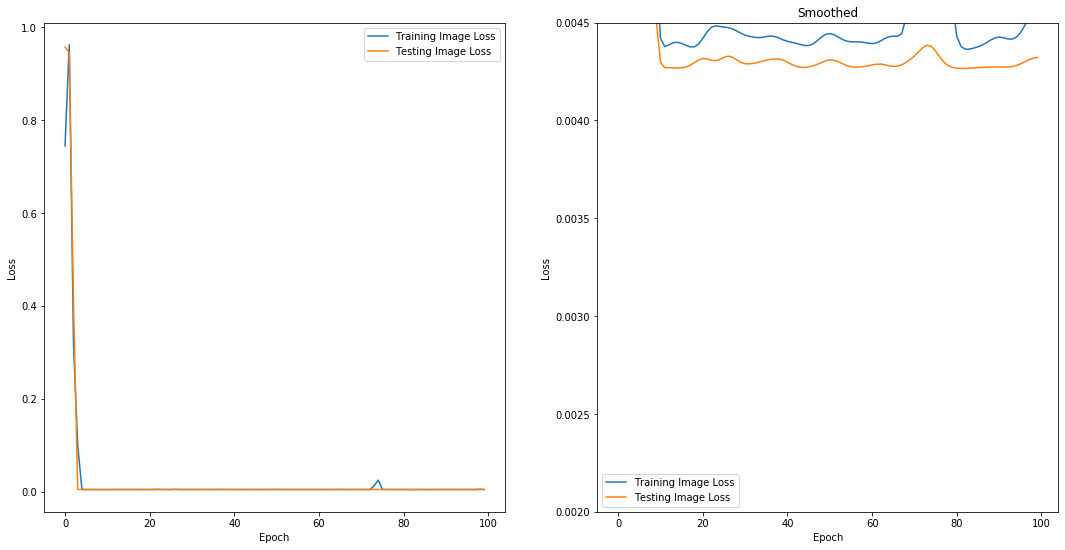

In [0]:
if not (LOAD_COLOURISATION_MODEL):
  fig = plt.figure(figsize=(38, 9))
  ax = fig.add_subplot(1,4,1)
  # plt.title("Fidelity")
  plt.plot(total_loss, label="Training Image Loss")
  if not (LOAD_COLOURISATION_MODEL):
    plt.plot(total_val_loss, label="Testing Image Loss")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig("Fidelity.png")
  # files.download("Fidelity.png") 

  ax = fig.add_subplot(1,4,2)
  ax.set_ylim([0.002,0.0045])
  plt.title("Smoothed")
  plt.plot(gaussian_filter1d(total_loss, sigma=2), label="Training Image Loss")
  if not (LOAD_COLOURISATION_MODEL):
    plt.plot(gaussian_filter1d(total_val_loss, sigma=2), label="Testing Image Loss")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig("Smooted.png")
  # files.download("Smooted.png") 

# Training Results

5000/5000 [==============================] - 0s 60us/sample - loss: 0.0044
0.004380197823047638


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


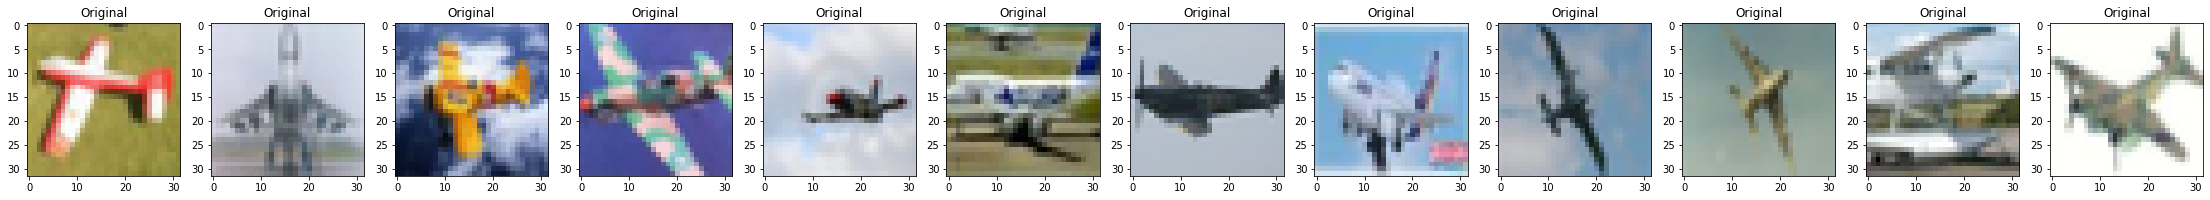

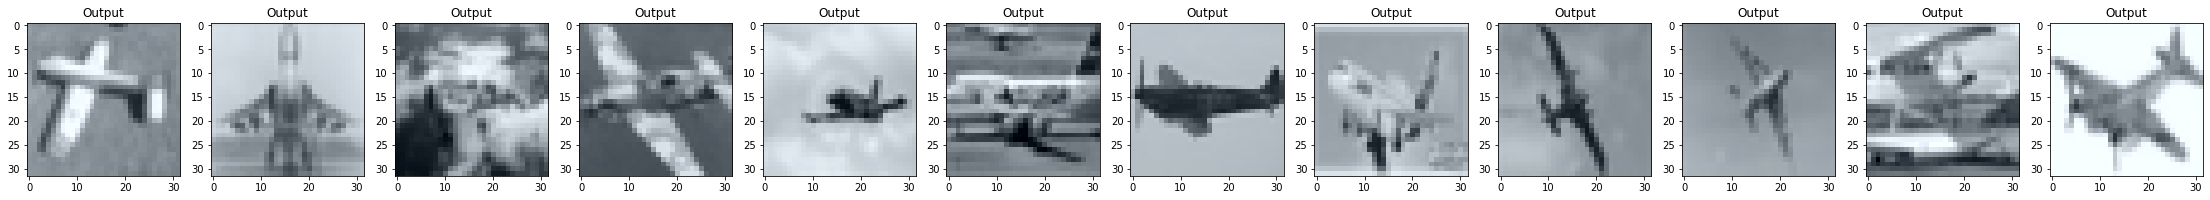

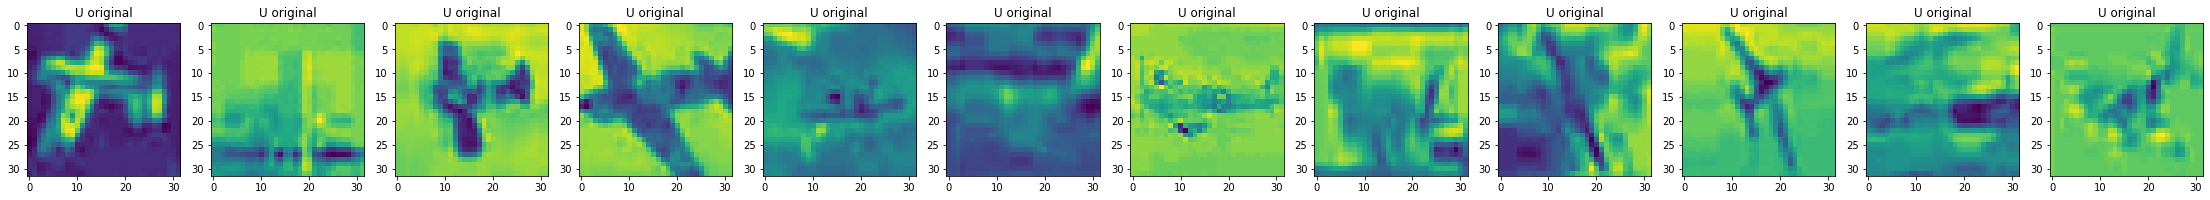

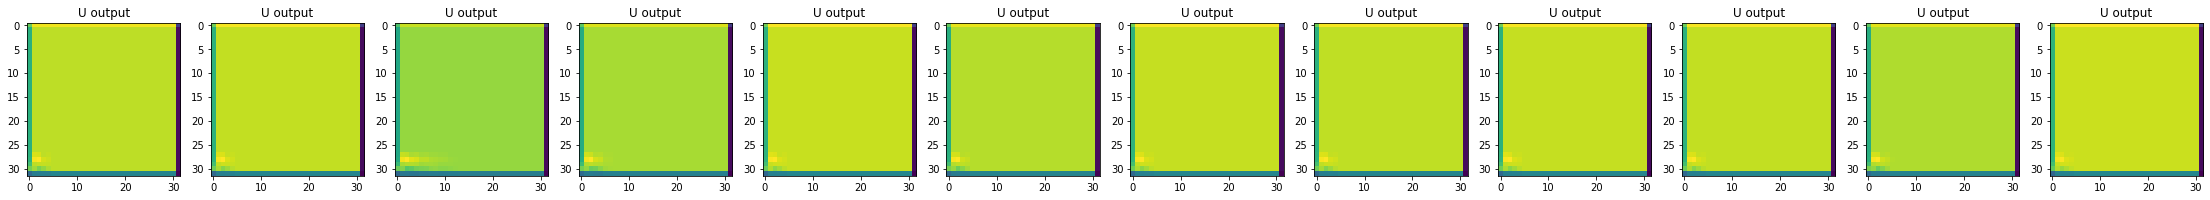

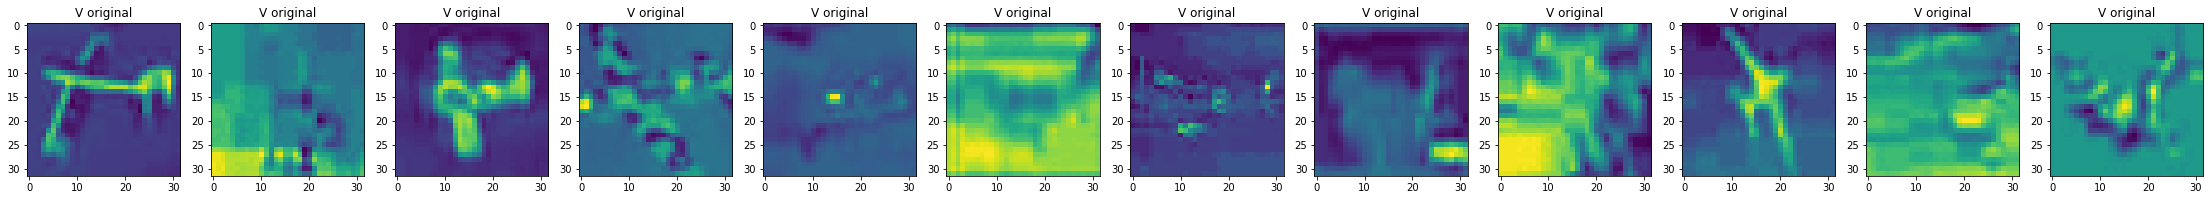

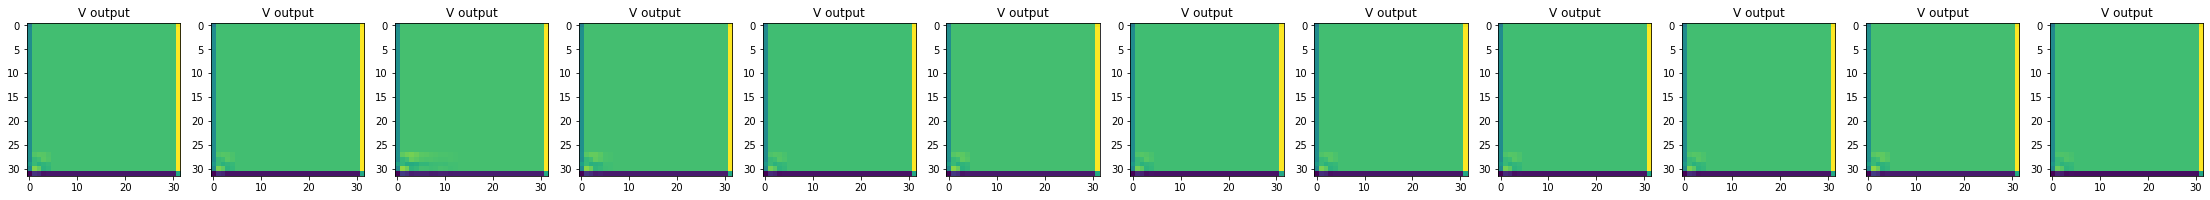

In [0]:
print(model.evaluate(train_y, train_uv, batch_size=BATCH_SIZE))
output = model.predict(train_y)
result = np.zeros((train_y.shape[0], 32, 32, 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(train_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])

# Testing Results

1000/1000 [==============================] - 0s 82us/sample - loss: 0.0043
0.0042706322856247425


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


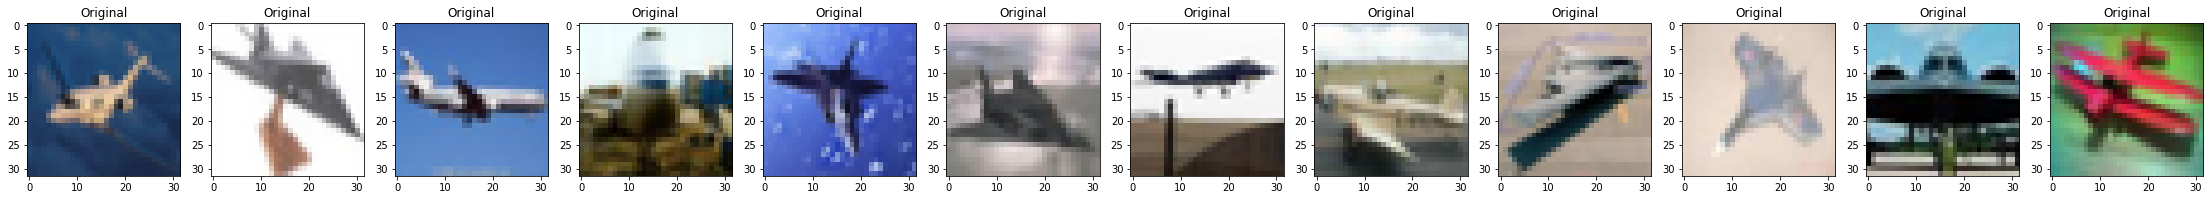

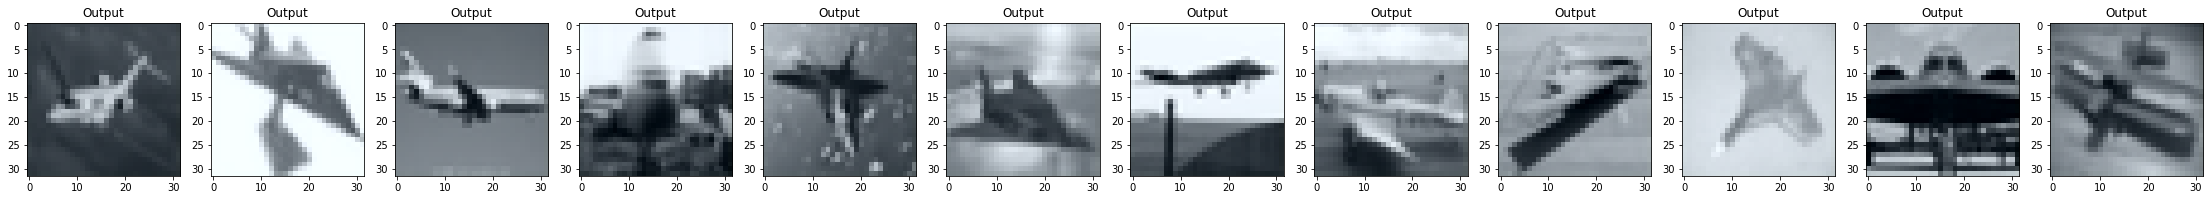

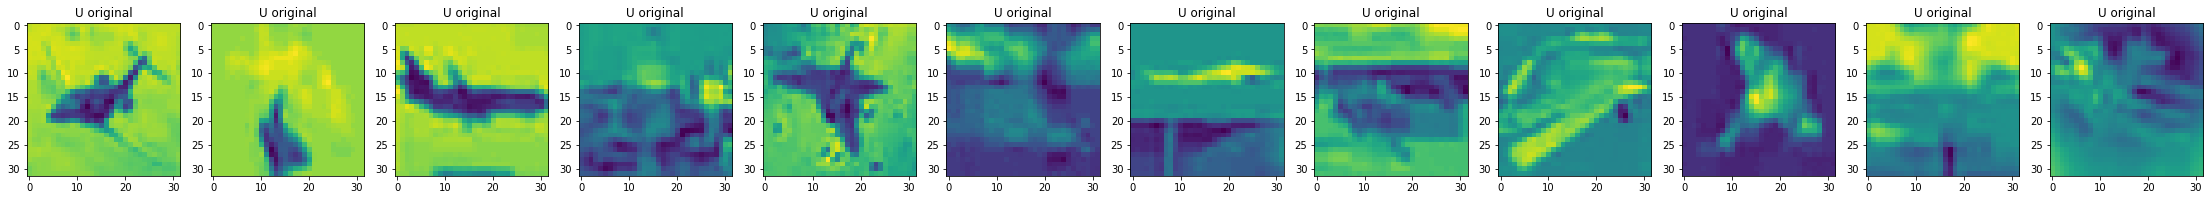

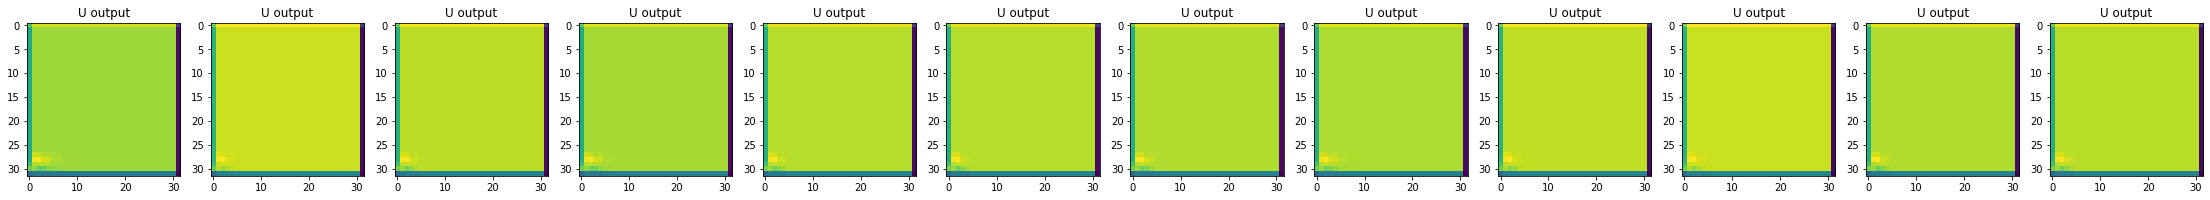

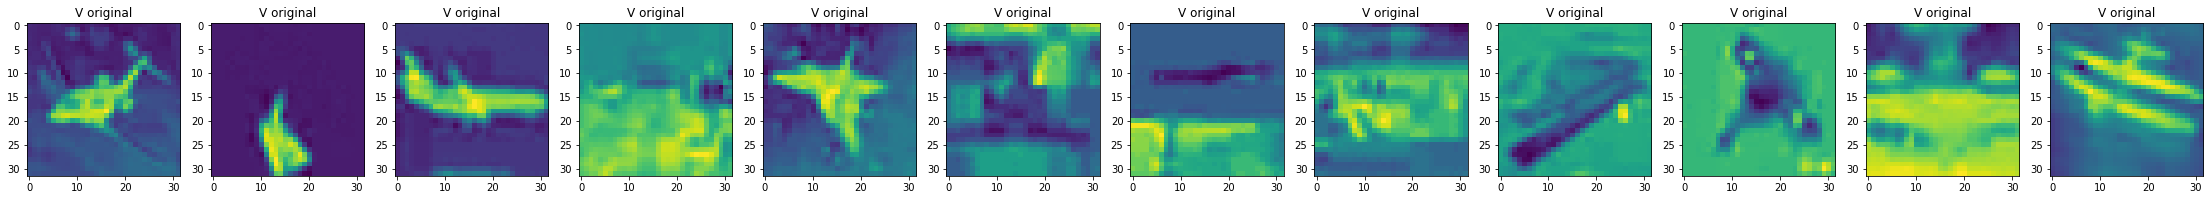

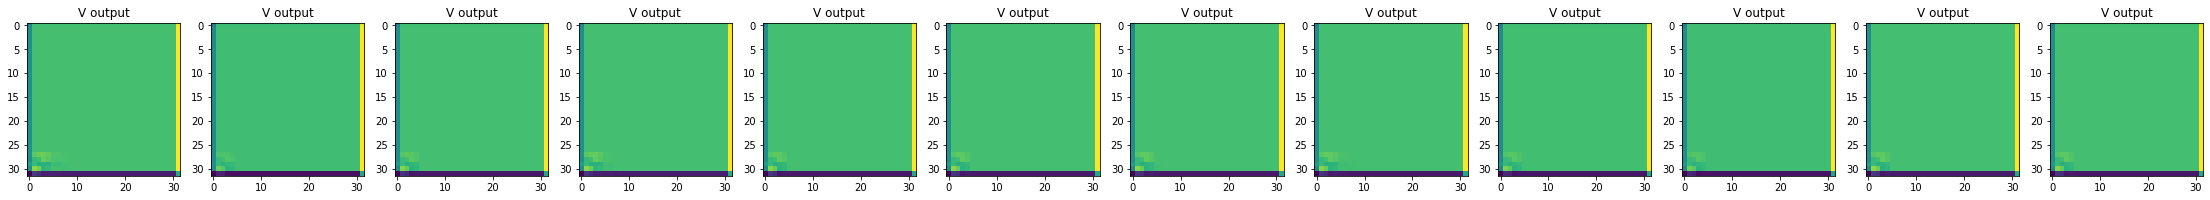

In [0]:
print(model.evaluate(test_y, test_uv, batch_size=BATCH_SIZE))
output = model.predict(test_y)
result = np.zeros((test_yuv.shape[0], 32, 32, 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(test_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])